In [1]:
# ================ Demand System ================
mutable struct DemandSystem
    Nodes # 2N length vector of xy-coords per node
    F     # N length vector of demand per node

    function DemandSystem(Nodes_in, F_in)
        new(Nodes_in, F_in)
    end
end

# --- Gets the coordinates of the ith node ---
function nCrd(M::DemandSystem, i)
    return M.Nodes[Int(2*i-1)], M.Nodes[Int(2*i)]
end

# --- Gets the demand of the ith node ---
function nDmd(M::DemandSystem, i)
    return M.F[Int(i)]
end


# ================ Design Variable ================
# --- Gets the coordinates of the kth station ---
function sCrd(x, k)
    return x[Int(4*k)-3], x[Int(4*k)-2]
end

# --- Gets the capacity of the kth station ---
function sCap(x, k)
    return x[Int(4*k)-1]
end

# --- Gets the building boolean of the kth station ---
function sB(x, k)
    return x[Int(4*k)]
end


# ================ Objective Function ================
# --- OBJECTIVE FUNCTION: Total cost of all stations ---
function cost(x, c, f)
    sz, sb = NaN, NaN
    sum = 0

    M = floor(length(x)/4)
    for k = 1:M
        sz = sCap(x, k)
        sb = sB(x, k)

        sum += (c + f*sz)*sb
    end
    return sum
end


# ================ Constraint Functions ================
# --- Squared distance between a node and a station ---
function i_kDist(nu, nv, sx, sy)
    return sqrt((nu-sx)*(nu-sx) + (nv-sy)*(nv-sy))
end

# --- INEQUALITY CONSTRAINT i: The ith node's demand is met by the stations ---
#       (  There are N constraints of this form. One for each i = 1,...,N  )
#       (  In the form of g_i(x) <= 0  )
function nodeConstraint_i(M::DemandSystem, x, i; r=-0.5)
    nx, ny = nCrd(M, i)
    F = nDmd(M, i)
    sum = 0

    M = length(x)/4
    for k = 1:M
        sx, sy = sCrd(x, k)
        sz     = sCap(x, k)
        sb     = sB(x, k)
        dist = i_kDist(nx, ny, sx, sy)

        sum += (sz*exp(r*dist))*sb
    end

    return F - sum
end 

# --- EQUALITY CONSTRAINT k: The kth station's b_k is a boolean --
#       (  There are M constraints of this form. One for each k = 1,...,M  )
#       (  In the form of h_k(x) = 0  )
function stationConstraint_k(x, k)
    sb = sB(x, k)
    return sb*sb - sb
end


# ================ Reading Data ================
# --- Takes a design variable and interprates it into meaningful data ---
#       (  Returns list of coordinates and capacity for built stations only  )
#       (  Returns [ (x,y,z), ..., (x,y,z) ] for built stations only  )
function readVariable(x)
    TOL = 1e-3
    
    result = []
    M = length(x)/4
    for k = 1:M
        sx, sy = sCrd(x, k)
        sz = sCap(x, k)
        sb = sB(x, k)

        if (abs(sb-1) <= TOL)
            push!(result, (sx, sy, sz))
        end
    end

    return result
end

readVariable (generic function with 1 method)

In [2]:
function simulated_annealing(f, x, T, t, k_max) 
    # optimization method used = Simulated Annealing
    # source(s) of code = Kochenderfer & Wheeler Textbook, Algorithm 8.4, page 130
    y = f(x)
    x_best, y_best = x, y
    count = 1
    for k in 1 : k_max
        x′ = x .+ (rand([-1, 1],T)).*rand(T)
        for i in 1:length(x)/4 
            x′[Int(4*i)] = rand(0:1)
            x′[Int(4*i-1)] = max(round(x′[Int(4*i-1)]), 0)
            x′[Int(4*i-3)] = (x′[Int(4*i-3)] >= 0 && x′[Int(4*i-3)] < max_x) ? x′[Int(4*i-3)] : x[Int(4*i-3)]
            x′[Int(4*i-2)] = (x′[Int(4*i-2)] >= 0 && x′[Int(4*i-2)] < max_y) ? x′[Int(4*i-2)] : x[Int(4*i-2)]
        end
        y′ = f(x′)
        Δy = y′ - y
        if Δy ≤ 0 || rand() < exp(-Δy/t(k))
            x, y = x′, y′ 
        end
        if y′ < y_best
            x_best, y_best = x′, y′ 
        end
        count += 1     # update number of function evaluations
    end
    return x_best, count
end

simulated_annealing (generic function with 1 method)

In [3]:
# Temperature scheduling (exponential annealing scheduling)
𝛄 = 0.99
t(k) = t0*(𝛄^(k-1))
t0 = 20

20

In [4]:
using LinearAlgebra
function simple_penalty(x, M, max_station)
    # simple penalty function: counts number of constraint equations violated
    gi_violated = 0
    hk_violated = 0
    for i in 1:length(x)/4
        nodeConstraint_i(M, x, i)>0 ? gi_violated+=1 : continue
    end
        
    return gi_violated 
end

function quadratic_penalty(x, M, max_station)
    # quadratic penalty function
    gi_violated = 0
    hk_violated = 0
    for i in 1:length(x)/4
        gi_violated += max(nodeConstraint_i(M, x, i),0)^2
    end
        
    return gi_violated
end


function penalty_method(f, p1, p2, x, k_max, c, f_cost, M, max_station; ρ1=3, ρ2=2, γ=3, max_iter=1000) 
    # source of code: Kochenderfer & Wheeler Textbook Algorithm 10.1, page 181
    convergence = -1
    x_new = x
    start = time()
    num_eval = 0
    for k in 1 : k_max
        x_new, count = simulated_annealing(x -> f(x, c, f_cost) + ρ1*p1(x, M, max_station) + ρ2*p2(x, M, max_station), x, T, t, max_iter) 
        num_eval = num_eval + count + 1
        ρ1 *= γ
        ρ2 *= γ
        convergence = norm(x_new - x)
        if p1(x_new, M, max_station)+p2(x_new, M, max_station) == 0
            return x_new, num_eval, time()-start, convergence 
        end
        x = x_new
    end
    return x, num_eval, time()-start, abs(convergence)
end

penalty_method (generic function with 1 method)

In [5]:
# ================ TEST MODEL ================
using Distributions
using LinearAlgebra
Nodes = [
    1.0, 1.0, 
    1.0, 2.0, 
    2.0, 1.0, 
    2.0, 2.0,

    3.0, 1.0,
    5.0, 4.0,
    6.0, 2.0,
    2.0, 6.0
];
max_x = 6
max_y = 6
F = [4, 5, 10, 8, 2, 4, 2, 1];
# F = [4, 5, 10, 8];
c, f = 10, 5

sys = DemandSystem(Nodes, F);
     

In [6]:
# ================ GENERATING MODEL ================
using Random
N = 8    # Number of nodes
c = 15.0 # Initial cost 
f_cost = 10.0 # Scaling cost
max_station = 3
x = Array{Float64}(undef, max_station*4)
for i in 1:max_station
    x[4*i - 3] = rand(1:6)
    x[4*i - 2] = rand(1:6)
    x[4*i - 1] = 0
    x[4*i] = 0
end
T=max_station*4
k_max = 2000
x, num_eval, comp_time, convergence = penalty_method(cost, simple_penalty, quadratic_penalty, x, 
                                        k_max, c, f_cost, sys, max_station)

([3.788453723113867, 1.5089384662196776, 1.0, 0.0, 2.0960369442881546, 0.8766328445314288, 11.0, 1.0, 2.6536367726471566, 3.781528773510832, 7.0, 0.0], 2004, 1.2529661655426025, 5.592089502817172)

In [7]:
# Print results

println(comp_time)
println(convergence)
println(num_eval)
println(cost(x,c,f_cost))
nc = 0
num = 0
for i in 1:3
    if x[4*i] == 1
        println(x[4*i - 3]," ", x[4*i - 2])
        println(x[4*i - 1])
        num += x[4*i - 1]
    end
    nc += nodeConstraint_i(sys, x, i)
end
println(nc)
println(num)

1.2529661655426025
5.592089502817172
2004
125.0
2.0960369442881546 0.8766328445314288
11.0
-2.528576482090047
11.0


In [8]:
# ============== Reading Real-life Dataset =================
using CSV 
 
Nodes = Array{Float64}(undef, 144)
F = Array{Float64}(undef, 72)

# reading the csv file 
csv_reader = CSV.File("/Users/briannagautama/Downloads/CS268_EVDemand_xy_normalized.csv")

count = 1
for row in csv_reader
    Nodes[2*count-1] = row.x
    Nodes[2*count] = row.y
    F[count] = row.EV_Demand
    count += 1
end

sys = DemandSystem(Nodes, F)
c = 3500   # initial cost
f_cost = 2000     # cost for scaling capacity

2000

In [9]:
x_node = [Nodes[2*i - 1] for i in 1:length(F)]
y_node = [Nodes[2*i] for i in 1:length(F)]
max_x = maximum(x_node)
max_y = maximum(y_node)

79.60425482077922

In [15]:
# Apply real-life data to simulated annealing with penalty method
max_station = 30
x = Array{Float64}(undef, max_station*4)
for i in 1:max_station
    x[4*i - 3] = rand(1:200)
    x[4*i - 2] = rand(1:70)
    x[4*i - 1] = 0
    x[4*i] = 0
end
T=max_station*4
k_max = 1000
x, num_eval, comp_time, convergence = penalty_method(cost, simple_penalty, quadratic_penalty, x, k_max, c, f_cost, sys, max_station, max_iter = 700)


([38.25306995875584, 70.39517919853708, 14.0, 1.0, 133.2751565408432, 72.99125726717426, 65.0, 0.0, 45.76704506577752, 7.195797192239719  …  82.0, 0.0, 206.81090951617847, 40.11493656643596, 15.0, 0.0, 110.03759623754225, 57.49138451739664, 117.0, 1.0], 702000, 310.06562995910645, 6.721641990087777)

In [16]:
# print results
println(comp_time)
println(convergence)
println(num_eval)
println(cost(x,c,f_cost))
nc = 0
num = 0
for i in 1:30
    if x[4*i] == 1
        println(x[4*i - 3]," ", x[4*i - 2])
        println(x[4*i - 1])
        num += x[4*i - 1]
    end
    nc += nodeConstraint_i(sys, x, i)
end
println(nc)
println(num)

310.06562995910645
6.721641990087777
702000
1.475e6
38.25306995875584 70.39517919853708
14.0
162.1564140342259 25.702655740708003
80.0
136.45253396367147 15.016282674931146
51.0
10.571206184369112 58.205532865520475
25.0
142.42320029721483 69.19512031611256
37.0
150.96139892620334 12.833871060236007
21.0
43.01319727789202 70.1304978863311
31.0
17.791511498470307 2.121248035813142
19.0
83.64748013948983 9.258343286939514
65.0
73.44240395883958 2.0765421962001662
10.0
2.410775554543369 30.14480756082987
79.0
11.49671533367683 60.88073548784202
123.0
120.22993280814589 43.58728705376436
41.0
110.03759623754225 57.49138451739664
117.0
-221.56325072972896
713.0


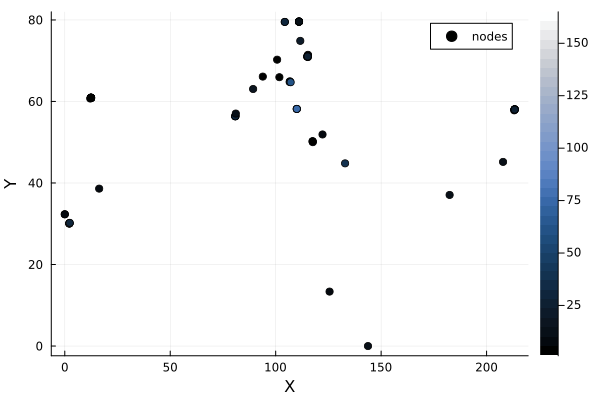

In [17]:
# Plot results
using Plots
x_coord = [x[4*i - 3] for i in 1:30 if x[4*i] == 1]
y_coord = [x[4*i - 2] for i in 1:30 if x[4*i] == 1]
z = [x[4*i - 1] for i in 1:30 if x[4*i] == 1]
plot(x_node, y_node, zcolor = F, seriestype=:scatter, xlabel="X", ylabel="Y",label="nodes", 
    color = palette(:oslo, length(unique(F))))

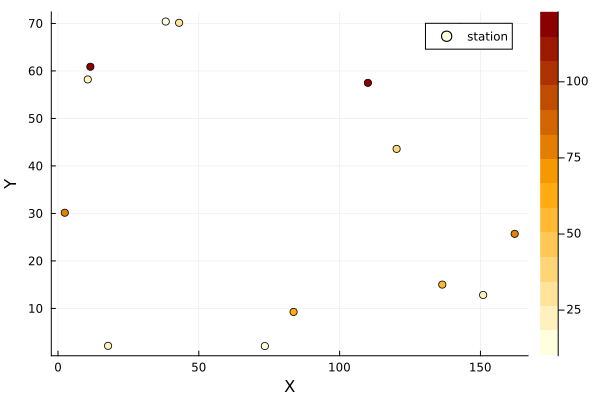

In [20]:
plot(x_coord, y_coord, zcolor = z, seriestype=:scatter, label="station", xlabel="X", ylabel="Y",
    color = palette(:heat, length(unique(z))))

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528


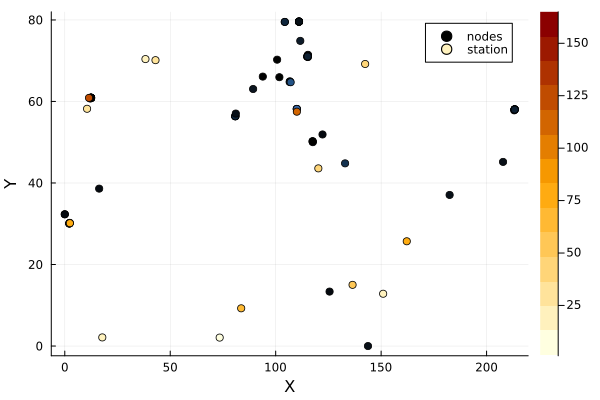

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528


In [21]:
plot(x_node, y_node, zcolor = F, seriestype=:scatter, xlabel="X", ylabel="Y",label="nodes", 
    color = palette(:oslo, length(unique(F))))
plot!(x_coord, y_coord, zcolor = z, seriestype=:scatter, label="station", 
    color = palette(:heat, length(unique(z))))